## Управление с прогнозируюшими моделями

Управление с прогнозирующими моделями подразумевает:
* наличие внутренней динамической (прогнозирующей) модели процесса $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u},t)$

* выбор целевой функции $J$ для оптимизации на основе прогнозирующей модели на конечном интервале времени (как правило соответствующем определённому числу тактов управления $P$, $P$ называется горизонтом планирования)

* выбор алгоритма оптимизации при помощи которого определяется минимум целевой функции $J$ по управлению $u$ на интервале времени $t \in [t_{k}, t_{k+P}]$

На каждом такте управления $t \in [t_{k}, t_{k+1}]$ решается задача оптимизации (возможно условной с любыми ограничениями на компоненты фазового вектора и управляющие параметры) после чего вкачестве значения функции управления на этом такте принимается равным $\mathbf{u}_k$, полученным как $argmin J$ на первом из $P$ тактов, вошедших в решение оптимизационной задачи.

В качестве примера целевой функции может быть рассмотрена

$$J = \sum_{k=1}^P{w_{x_k}}(\mathbf{r}_k - \mathbf{x}_k)^2 + \sum_{k=1}^P{w_{u}}(\mathbf{u}_{max} - \mathbf{u}_k)^2,$$

где

$\mathbf{x}_k$ - значения вектора фазовых пременных системы на такте $k$,

$\mathbf{r}_k$ - задающий сигнал, который должна воспроизводить система управления,

$\mathbf{u}_k$ - значения вектора управляющих параметров системы на такте $k$,

$\mathbf{u}_{max}$ - значения ограничений на компоненты вектора управляющй параметров системы,

$w_{x_k}$, $w_{u}$, - вестовые коэффициенты.

## Пример. Обращенный маятник на тележке

### Обозначения
$s : смещение \ тележки\ [м]; $ 

$\alpha : угол,\ который\ образует\ маятник\ с\ вертикалью\ [rad]; $

$u  : сила,\ приложенная\ к\ тележке,\ действующая\ как\ управляющий\ вход\ [Н]; $

$m  : масса\ тележки\ [кг]; $

$M  :  масса\ маятника\ [кг]; $

$l : длина\ маятника\ [м]; $

$g : ускорение\ свободного\ падения\ [м/с^2]; $

### Уравнения Лагранжа

Кинетическая энергия
$$T = \frac{m}{2}\left[(l\dot{\alpha}\cos{\alpha}+ \dot{s})^2 + (l\dot{\alpha}\sin{\alpha})^2\right] + \frac{M}{2}\dot{s}^2$$


Потенциальная энергия
$$\Pi = mgl\cos{\alpha}$$


Уравнения Лагранжа
\begin{array}\\
ml^2\ddot{\alpha} + ml\ddot{s}\cos{\alpha} - ml\dot{s}\dot{\alpha}\sin{\alpha}- mgl\sin{\alpha} = 0 \\
ml\ddot{\alpha}\cos{\alpha} + (m + M)\ddot{s} - ml\dot{\alpha}^2\sin{\alpha} = u
\end{array}
\right. 
$$

В нормальной форме Коши уравнения обращённого маятника имеют вид:
$$\left\{ 
\begin{array}\\
\dot{\alpha} = \omega \\
\dot{\omega} = \frac{1}{(M+m\sin{\alpha}^2)l} \left[(M+m)g\sin{\alpha} - ml\omega^2\sin{\alpha}\cos{\alpha}-u\cos{\alpha}\right] \\
\dot{s} = v \\
\dot{v} = \frac{1}{(M+m\sin{\alpha}^2)} \left[-mg\sin{\alpha}\cos{\alpha} + ml\omega^2\sin{\alpha} + u\right]
\end{array}
\right. 
$$

### После упрощения и линеаризации*

\begin{equation*}
\begin{pmatrix}
  \dot{\alpha} \\ \dot{\omega} \\ \dot{s} \\ \dot{v}
\end{pmatrix} = 
 \begin{bmatrix}
0& 1& 0& 0&\\
(M + m) \cdot g & 0& 0& 0& \\
0& 0& 0& 1& \\
 - m \cdot g \cdot l& 0& 0& 0
\end{bmatrix} \cdot {\begin{pmatrix}
  \alpha \\ \omega \\ s \\ v
\end{pmatrix}}\cdot\frac{1}{M l} + {\begin{pmatrix}
  0 \\ -1 \\ 0 \\ l
\end{pmatrix}}\cdot\frac{u}{M l}
\end{equation*}

*В коде ниже  для сравнения реализованы обе модели (и полная и линеаризованная)

In [81]:
import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp 
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [82]:
class Parameters(object):
    pass
sim = Parameters()
sim.time = 40
sim.step = 0.1
sim.t = np.arange(0, sim.time, sim.step)
sim.loop_count = len(sim.t)

cnst = Parameters()
cnst.g = 9.81
cnst.m = 1
cnst.M = 10
cnst.L = 1
cnst.A = np.array([[0, 1, 0, 0],
                  [ (cnst.M + cnst.m) * cnst.g, 0, 0,  0], 
                  [0, 0, 0, 1],  
                  [-cnst.m * cnst.g * cnst.L, 0, 0, 0]]) / (cnst.M * cnst.L)
cnst.b = np.array([0,  -1 , 0, cnst.L]) / (cnst.M * cnst.L)
cnst.u_max = 50

#### Структура mpc ниже содержит параметры, определяющие состав целевой функции и интервал, на котором производится решение оптимизационной задачи:

In [83]:
mpc = Parameters()
mpc.p_horizon = 10           # горизонт прогноза
mpc.c_horizon = 5            # горизонт управления
mpc.constraintpenalty = 10   # штраф за превышение ограничений на управление при составлении целевой функции в оптимизации
mpc.movepenalty = 0          # штраф за изменение управления на одном шаге при составлении целевой функции в оптимизации
mpc.strongfinish = 10        # штраф за отклонение последнего значения от цели

In [84]:
def rhs(t, x, u):   
    cosA = np.cos(x[0])
    sinA = np.sin(x[0])
    p = cnst
    
    x_dot = np.zeros(4)
    
    x_dot[0] = x[1]
    x_dot[1] = ( (p.M + p.m) * p.g * sinA - p.m * p.L * x[1]**2 * sinA * cosA - u * cosA ) / (p.M + p.m * sinA**2) / p.L
    x_dot[2] = x[3]
    x_dot[3]=  ( -p.m * p.g * sinA * cosA + p.m * p.L * x[1]**2 * sinA + u ) / (p.M + p.m * sinA**2) / p.L
    
    return x_dot

def simiplified_model(t, x, u):
    return cnst.A.dot(x) + cnst.b.dot(u)

def cost_function(u_mpc):
    x_pred = np.zeros((len(u_mpc)+1, 4))
    x_pred[0, :] = states[i-1, :] 
    
    for k in range(0, len(u_mpc)):       
        time_span = [0, sim.step]
        sol = solve_ivp(lambda t, x: rhs(t, x, u_mpc[0]), time_span, x_pred[k, :])
        x_pred[k+1, :] = sol.y.T[-1]

    cost_integral = np.sum(np.square(x_pred[:, 0]))

    u_mpc_magnitude = np.abs(u_mpc)
    cost_constraint = mpc.constraintpenalty * np.sum(u_mpc_magnitude[u_mpc_magnitude > cnst.u_max])
    
    if len(u_mpc) > 1:
        cost_move = mpc.movepenalty * np.max(np.abs(np.diff(u_mpc)))
    else:
        cost_move = 0
        
    cost_finish = mpc.strongfinish * x_pred[-1, 0]**2
    
    total_cost = cost_integral + cost_constraint + cost_move + cost_finish
        
    return total_cost

In [85]:
u = np.zeros(sim.loop_count)
u_optimized = np.zeros(mpc.p_horizon)
states = np.zeros((sim.loop_count, 4))

# инициализация
states[0, :] = np.array([ np.pi * 20 / 180, 0, 0, 0])
print('cur_state:', states[0, :] )

for i in range(1, sim.loop_count):
    ts = [sim.step * (i-1), sim.step * i]
    sol_i = solve_ivp(lambda t, x: rhs(t, x, u[i]), ts, states[i-1, :])
    states[i, :] = sol_i.y.T[-1]
    print('cur_state:', states[i, :])
    
    # инициализация
    len_to_end = min(mpc.p_horizon, sim.loop_count - i)
    u_mpc0 = np.zeros(len_to_end)
    u_mpc0 = u_optimized[0: min(len_to_end, mpc.p_horizon)]
    
    solution = minimize(cost_function, u_mpc0, method='SLSQP')
    u_optimized = solution.x  

    if i < sim.loop_count - 1:
        u[i+1] = u_optimized[0]

cur_state: [0.34906585 0.         0.         0.        ]
cur_state: [ 0.36745155  0.37062235 -0.00156528 -0.0314438 ]
cur_state: [0.40467424 0.38090084 0.0146964  0.356096  ]
cur_state: [0.44175911 0.36801686 0.07314259 0.81222758]
cur_state: [0.47971583 0.39844271 0.17702644 1.26488381]
cur_state: [0.52298856 0.47526199 0.32600596 1.71413244]
cur_state: [0.57657904 0.60658466 0.51973608 2.15987918]
cur_state: [0.64656539 0.80589568 0.75786605 2.60217807]
cur_state: [0.74065705 1.09235592 1.04008375 3.04190946]
cur_state: [0.86875334 1.49044229 1.36626262 3.48224492]
cur_state: [1.04339736 2.02807772 1.73681939 3.93149853]
cur_state: [1.30010793 3.10053875 2.10747857 3.49437477]
cur_state: [1.66138388 4.10832658 2.43878823 3.14898593]
cur_state: [2.11667069 4.959407   2.74041959 2.8947222 ]
cur_state: [2.64142308 5.44904242 3.01785766 2.64079398]
cur_state: [3.18379062 5.27038634 3.26317401 2.23026295]
cur_state: [3.67308674 4.43533694 3.45784273 1.64460735]
cur_state: [4.06191562 3.32

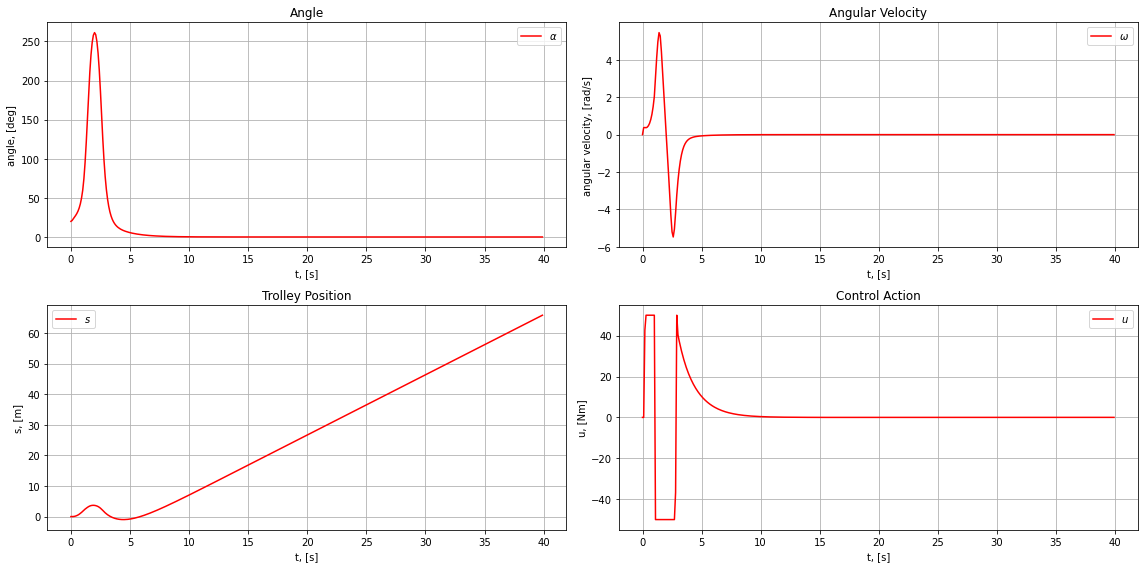

In [86]:
# визуализация   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Angle")
ax1.plot(sim.t, states[:, 0] * 180. / np.pi, label = r'$ \alpha $', color = 'red')
ax1.set_ylabel(r'angle, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(sim.t, states[:, 1], label = '$\omega$', color = 'red')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax3 = fig1.add_subplot(2,2,3)

ax3.set_title("Trolley Position")
ax3.plot(sim.t, states[:, 2], label = '$s$', color = 'red')
ax3.set_ylabel(r's, [m]')
ax3.set_xlabel(r't, [s]')
ax3.grid(True)
ax3.legend()

ax4 = fig1.add_subplot(2,2,4)

ax4.set_title("Control Action")
ax4.plot(sim.t, u, label = '$u$', color = 'red')
ax4.set_ylabel(r'u, [Nm]')
ax4.set_xlabel(r't, [s]')
ax4.grid(True)
ax4.legend()

plt.tight_layout()

### Библиотеки, реализующие MPC

[Model predictive control python toolbox](https://www.do-mpc.com/en/latest/)

[GEKKO](https://gekko.readthedocs.io/en/latest/imode.html?highlight=mpc#mpc)

[Dynamics and control with jupyter notebooks](https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html)